In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

# from transformers import TrainingArguments, Trainer

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from linear_attention_transformer.linear_attention_transformer import LinearAttentionTransformer
from linear_attention_transformer.linear_attention_transformer import LinearAttentionTransformerLM

from linear_attention_transformer.autoregressive_wrapper import AutoregressiveWrapper
from linear_attention_transformer.autopadder import Autopadder
# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


In [2]:
from sklearn.preprocessing import StandardScaler
import numpy as np

fold_pamap = "../down_stream_dataset/adl_dataset/"
train_xyz = np.load(f"{fold_pamap}x_train.npy")
valid_xyz = np.load(f"{fold_pamap}x_valid.npy")
test_xyz = np.load(f"{fold_pamap}x_test.npy")
train_label = np.load(f"{fold_pamap}y_train.npy")
valid_label = np.load(f"{fold_pamap}y_valid.npy")
test_label = np.load(f"{fold_pamap}y_test.npy")

# データの形を確認
print(f"Train data shape: {train_xyz.shape}, Train label shape: {train_label.shape}")
print(f"Valid data shape: {valid_xyz.shape}, Valid label shape: {valid_label.shape}")
print(f"Test data shape: {test_xyz.shape}, Test label shape: {test_label.shape}")

# 各データセットを個別に標準化
scaler_train = StandardScaler()
scaler_valid = StandardScaler()
scaler_test = StandardScaler()

# train_xyz の標準化
train_xyz_reshaped = train_xyz.reshape(-1, train_xyz.shape[-1])  # 2Dに変換
scaled_train_xyz = scaler_train.fit_transform(train_xyz_reshaped)  # 標準化
scaled_train_xyz = scaled_train_xyz.reshape(train_xyz.shape)  # 元の形に戻す

# valid_xyz の標準化
valid_xyz_reshaped = valid_xyz.reshape(-1, valid_xyz.shape[-1])  # 2Dに変換
scaled_valid_xyz = scaler_valid.fit_transform(valid_xyz_reshaped)  # 標準化
scaled_valid_xyz = scaled_valid_xyz.reshape(valid_xyz.shape)  # 元の形に戻す

# test_xyz の標準化
test_xyz_reshaped = test_xyz.reshape(-1, test_xyz.shape[-1])  # 2Dに変換
scaled_test_xyz = scaler_test.fit_transform(test_xyz_reshaped)  # 標準化
scaled_test_xyz = scaled_test_xyz.reshape(test_xyz.shape)  # 元の形に戻す

# 各データセットの形状を再確認
print(f"Scaled Train data shape: {scaled_train_xyz.shape}")
print(f"Scaled Valid data shape: {scaled_valid_xyz.shape}")
print(f"Scaled Test data shape: {scaled_test_xyz.shape}")


Train data shape: (406, 3, 300), Train label shape: (406,)
Valid data shape: (102, 3, 300), Valid label shape: (102,)
Test data shape: (127, 3, 300), Test label shape: (127,)
Scaled Train data shape: (406, 3, 300)
Scaled Valid data shape: (102, 3, 300)
Scaled Test data shape: (127, 3, 300)


In [3]:
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())
print(pd.Series(valid_label).value_counts())


4    186
1     62
2     58
3     54
0     46
dtype: int64
4    51
1    25
3    22
2    19
0    10
dtype: int64
4    42
1    18
3    17
2    15
0    10
dtype: int64


In [4]:
train_xyz = scaled_train_xyz
valid_xyz = scaled_valid_xyz
test_xyz = scaled_test_xyz

In [5]:
num_classes = len(np.unique(train_label))  # クラス数
print(num_classes)
dim = 768
depth = 8
heads = 12
dropout = 0.1

class Config:
    def __init__(self, dim, depth, max_seq_len, heads, causal):
        self.dim = dim
        self.depth = depth
        self.max_seq_len = max_seq_len
        self.heads = heads
        self.causal = causal

config = Config(
    dim=768,
    depth=8,
    max_seq_len=300,
    heads=12,
    causal=True
)

# `config` の属性を展開して渡す
model = LinearAttentionTransformerLM(
    dim=config.dim,
    depth=config.depth,
    max_seq_len=config.max_seq_len,
    heads=config.heads,
    causal=config.causal
)
state_dict = torch.load('path/pretrained_1/5_4pretrain_model_predict.pth')

# キー名の修正
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace("weights_", "weights.")  # キー名の変更
    new_state_dict[new_key] = value

# 修正済みの重みをモデルにロード
model.load_state_dict(new_state_dict, strict=True)
model.to(device)


5


RuntimeError: Error(s) in loading state_dict for LinearAttentionTransformerLM:
	Unexpected key(s) in state_dict: "norm.weight", "norm.bias", "out.weight", "out.bias", "predict.weight", "predict.bias". 

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class ClassificationDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self._data = data 
        self._labels = labels  

    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
        return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)


In [7]:
train_label = torch.tensor(train_label, dtype=torch.long)
test_label = torch.tensor(test_label, dtype=torch.long)
valid_label = torch.tensor(valid_label, dtype=torch.long)

train_label = train_label - train_label.min()
test_label = test_label - test_label.min()
valid_label = valid_label - valid_label.min()


In [8]:
train_dataset = ClassificationDataset(train_xyz, train_label)
test_dataset = ClassificationDataset(test_xyz, test_label)
valid_dataset = ClassificationDataset(valid_xyz, valid_label)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [9]:
import torch
import torch.nn as nn

class TrainModel(LinearAttentionTransformerLM):
    def __init__(self, num_classes, dim=768, depth=8, max_seq_len=300, heads=12, causal=True):
        # 親クラスの初期化に必要な引数を渡す
        super().__init__(dim=dim, depth=depth, max_seq_len=max_seq_len, heads=heads, causal=causal)
        self.fc1 = nn.Linear(768 * 3, 768)
        self.fc2 = nn.Linear(768, num_classes)

    def forward(self, x):
        features = super().forward(x)  
        out_x = features[:, 0, :]
        out_y = features[:, 1, :]
        out_z = features[:, 2, :]
        combined = torch.cat((out_x, out_y, out_z), dim=1)
        output = F.relu(self.fc1(combined))
        output = self.fc2(output)
        return output
# モデルの作成例
train_model = TrainModel(num_classes=num_classes, dim=768, depth=8, max_seq_len=300, heads=12, causal=True)
train_model.to(device)


TrainModel(
  (token_emb): Linear(in_features=300, out_features=768, bias=True)
  (pos_emb): AxialPositionalEmbedding(
    (weights): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1x3x1x768 (GPU 0)]
        (1): Parameter containing: [torch.float32 of size 1x1x128x768 (GPU 0)]
    )
  )
  (transformer): LinearAttentionTransformer(
    (layers): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): SelfAttention(
              (local_attn): LocalAttention(
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (to_q): Linear(in_features=768, out_features=768, bias=False)
              (to_k): Linear(in_features=768, out_features=768, bias=False)
              (to_v): Linear(in_features=768, out_features=768, bias=False)
              (to_out): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
     

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(train_model.parameters(), lr=1e-4)

num_epochs = 100

train_loss = []
validation_losses = []
best_valid_loss = float('inf')
best_model_path = 'path/best_model_adl_768.pth'

time_epoch = 0

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0
    
    val_correct = 0
    val_total = 0
    total_val_loss = 0
    
    train_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # 順伝播
        outputs = train_model(inputs)
        loss = criterion(outputs, labels)
        # 逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 統計
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_loss.append(total_loss / len(train_loader))
    
    train_model.eval()  # Set model to evaluation mode
    
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = train_model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()
            
            # 統計
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_targets.size(0)
            val_correct += (val_predicted == val_targets).sum().item()
            
        if total_val_loss < best_valid_loss:
            best_valid_loss = total_val_loss
            torch.save(train_model.state_dict(), best_model_path)
            time_epoch = epoch + 1
    validation_losses.append(total_val_loss / len(val_loader))
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, valid Loss: {total_val_loss / len(val_loader)}, Accuracy: {100 * correct / total:.2f}%, Val Accuracy: {100 * val_correct / val_total:.2f}%")
train_model.load_state_dict(torch.load(best_model_path))
print("Best model reloaded with valid loss: ", best_valid_loss/ len(val_loader), f"  time: {time_epoch}")
    

/tmp/ipykernel_93223/3962539304.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)


Epoch 1/100, Loss: 1.9004, valid Loss: 1.0255758464336395, Accuracy: 32.02%, Val Accuracy: 59.80%
Epoch 2/100, Loss: 0.9239, valid Loss: 0.7781774699687958, Accuracy: 65.27%, Val Accuracy: 66.67%
Epoch 3/100, Loss: 0.6698, valid Loss: 0.9049516022205353, Accuracy: 74.38%, Val Accuracy: 75.49%
Epoch 4/100, Loss: 0.7069, valid Loss: 0.6426544189453125, Accuracy: 76.11%, Val Accuracy: 77.45%
Epoch 5/100, Loss: 0.5646, valid Loss: 0.5268474221229553, Accuracy: 79.56%, Val Accuracy: 80.39%
Epoch 6/100, Loss: 0.4582, valid Loss: 0.4938208609819412, Accuracy: 83.25%, Val Accuracy: 82.35%
Epoch 7/100, Loss: 0.4693, valid Loss: 0.6376226842403412, Accuracy: 84.24%, Val Accuracy: 52.94%
Epoch 8/100, Loss: 0.4810, valid Loss: 0.544695720076561, Accuracy: 82.27%, Val Accuracy: 81.37%
Epoch 9/100, Loss: 0.3968, valid Loss: 0.5907057225704193, Accuracy: 83.74%, Val Accuracy: 79.41%
Epoch 10/100, Loss: 0.3982, valid Loss: 0.49220700562000275, Accuracy: 85.47%, Val Accuracy: 83.33%
Epoch 11/100, Loss:

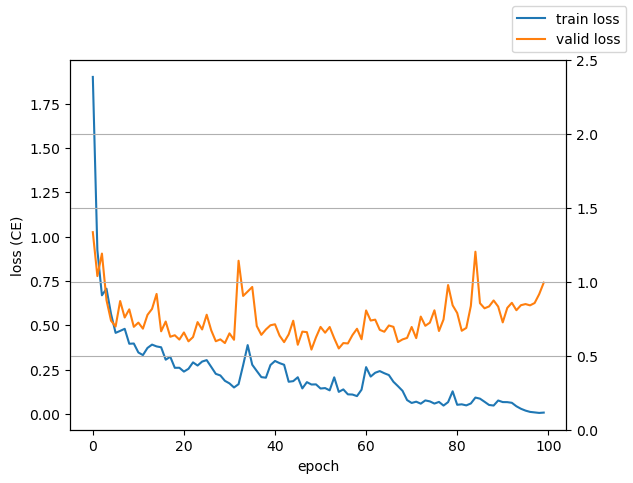

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.close('all')
fig, ax = plt.subplots()
ax.plot(train_loss, color='C0', label='train loss')
ax.plot(validation_losses, color='C1', label='valid loss')

ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')

# 二軸グラフの追加
ax2 = ax.twinx()
ax2.grid(True)

# 凡例の表示
fig.legend(loc='upper right')
plt.ylim(0.0, 2.50)
# グラフの表示
plt.show()


/tmp/ipykernel_93223/3962539304.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)


Test Accuracy: 92.126%

Classification Report:
              precision    recall  f1-score   support

           0      0.714     0.500     0.588        10
           1      0.962     1.000     0.980        25
           2      0.941     0.842     0.889        19
           3      1.000     1.000     1.000        22
           4      0.891     0.961     0.925        51

    accuracy                          0.921       127
   macro avg      0.902     0.861     0.876       127
weighted avg      0.917     0.921     0.917       127



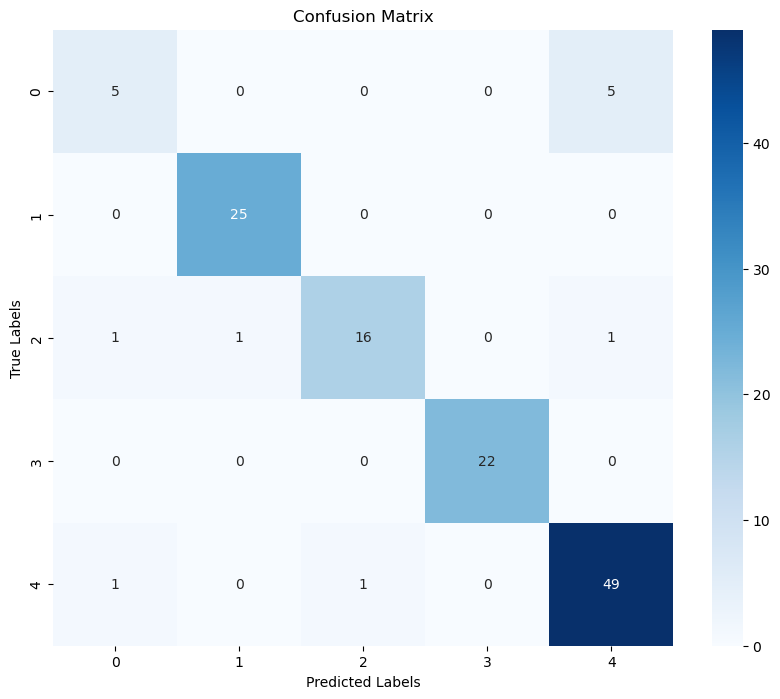

In [12]:
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_model(model, test_loader, device):
    model.eval()
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # 小数点3桁で精度表示
    test_accuracy = round(100 * test_correct / test_total, 3)
    print(f"Test Accuracy: {test_accuracy:.3f}%")

    # 分類レポートを小数点3桁で表示
    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, zero_division=0, digits=3)
    print(report)

    # 混同行列の計算と表示
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return test_accuracy, all_preds, all_labels


test_accuracy, test_preds, test_labels = evaluate_model(train_model, test_loader, device)


In [20]:
val_mean = sum(validation_losses)/100
val_max = max(validation_losses)
val_min = min(validation_losses)

first = validation_losses[0]
end = validation_losses[99]
print("mean  ",val_mean)
print("max   ", val_max)
print("min   ", val_min)
print("first ", first)
print("end   ", end)

mean   0.5349094128608703
max    1.0255758464336395
min    0.36399517953395844
first  1.0255758464336395
end    0.7410828024148941
